> __Purpose:__ This NB visualizes the results of the full study for various feature engineering approaches. I didn't do any NAS hyperparam tuning, just eyeballed what seemed reasonable based on previous results. Maybe turn off Earlystopping?

In [1]:
import numpy as np
#from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
#import pandas as pd

from global_seed import set_seed
set_seed()

from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import * 
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Global seed set to 17
Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\April_25


In [2]:
# Code that saved metadata_EMG_allgestures_allusers directly from Box:
## https://github.com/kdmalc/fl-gestures/blob/18e03ed08dacbde76dc8b1b4c822893a0045b057/archive/June_14_24/001_LoadingAndSavingDataframes.ipynb#L1232

filtered_emg_df = load_expdef_gestures(feateng_method=None, filepath_pkl='C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\metadata_EMG_allgestures_allusers.pkl')

In [3]:
filtered_emg_df.head()

,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P102,pan,1,"[[1.1236723395967384e-06, 1.0462375253174433e-...",5,6
1,P102,pan,2,"[[1.001410892643185e-06, 1.422822061579333e-06...",5,6
2,P102,pan,3,"[[1.2884891704573043e-06, 1.2073677862917166e-...",5,6
3,P102,pan,4,"[[1.178189230006332e-06, 1.1569560939239187e-0...",5,6
4,P102,pan,5,"[[1.2201100012557717e-06, 1.1574615773545197e-...",5,6


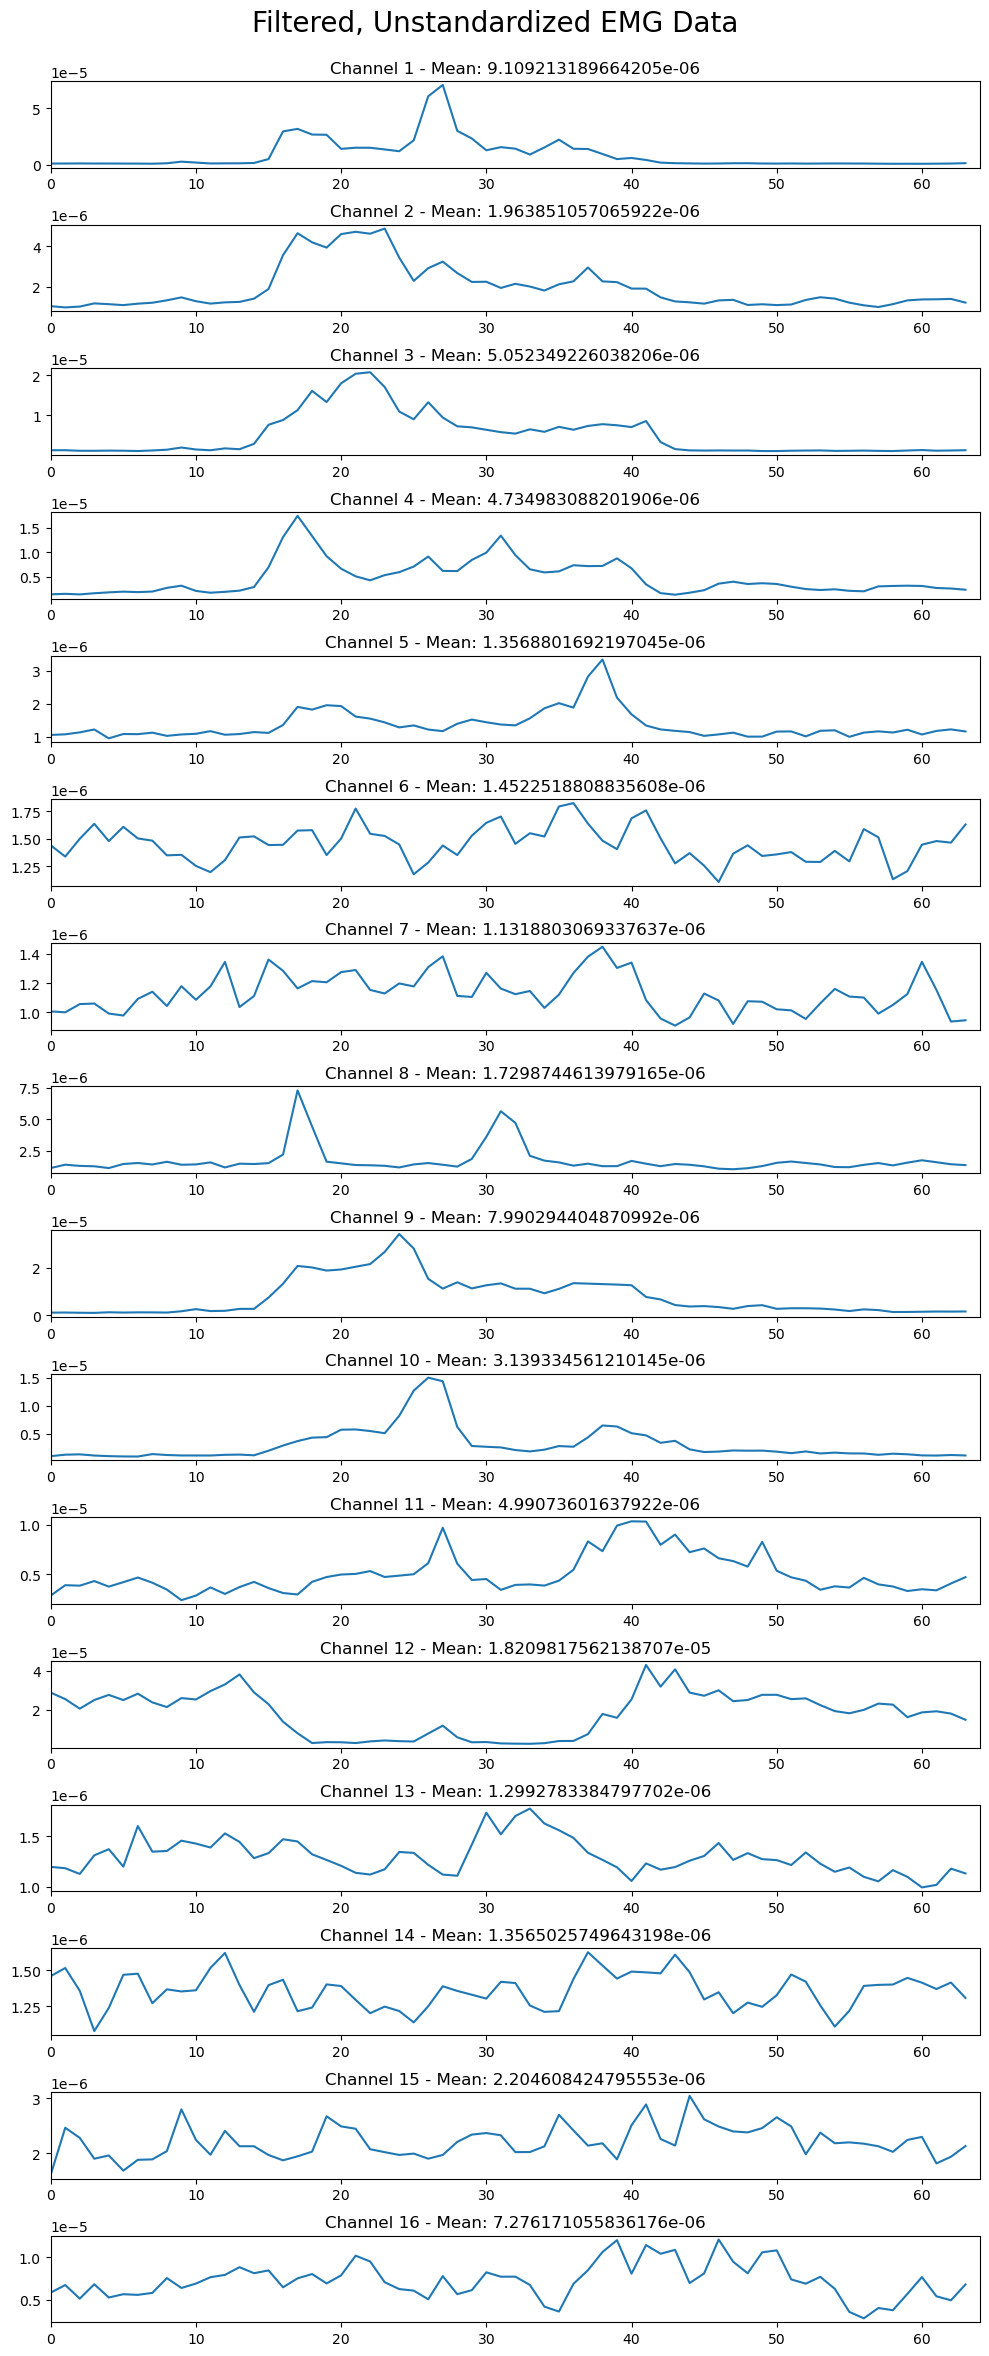

In [4]:
fig, axs = plt.subplots(16, 1, figsize=(10, 1.5*16))

for i in range(16):
    channel_data = filtered_emg_df.iloc[0, 3][:, i]
    channel_mean = np.mean(channel_data)
    axs[i].plot(channel_data)
    axs[i].set_title(f'Channel {i + 1} - Mean: {channel_mean}')
    axs[i].set_xlim(0, len(channel_data))  # Set x limits to make all subplots the same width

plt.tight_layout()
plt.suptitle('Filtered, Unstandardized EMG Data', fontsize=20)
plt.subplots_adjust(top=0.95)  
plt.show()

In [18]:
NUM_MONTE_CARLO_RUNS = 1  # HARDCODING 1 in: if you want to run more you have to edit the code...
SAVE_FIGS = False
LOCAL_USERS_LIMIT = 10  # For saving time... skews it a bit tbf
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

import json
# Load the fixed user splits
with open("fixed_user_splits\\24_8_user_splits_RS17.json", "r") as f:
    splits = json.load(f)
all_participants = splits["all_users"]
test_participants = splits["test_users"]

In [6]:
#"CNNLSTM": DynamicCNNLSTM_config
#"CNN": DynamicCNN_config

# OVERWRITE THESE FOR EACH CONFIG
DynamicCNN_config["user_split_json_filepath"] = "fixed_user_splits\\24_8_user_splits_RS17.json"
DynamicCNNLSTM_config["user_split_json_filepath"] = "fixed_user_splits\\24_8_user_splits_RS17.json"


## No feature engineering:

In [7]:
FEATURE_ENGR_METHOD = None

In [8]:
DynamicCNN_config["feature_engr"] = FEATURE_ENGR_METHOD
DynamicCNNLSTM_config["feature_engr"] = FEATURE_ENGR_METHOD
expdef_df_None = load_expdef_gestures(feateng_method=FEATURE_ENGR_METHOD)
shared_None_data_splits_lst = create_shared_trial_data_splits(expdef_df_None, all_participants, test_participants, num_monte_carlo_runs=NUM_MONTE_CARLO_RUNS, num_train_gesture_trials=8, num_ft_gesture_trials=3)
shared_None_data_splits = shared_None_data_splits_lst[0]

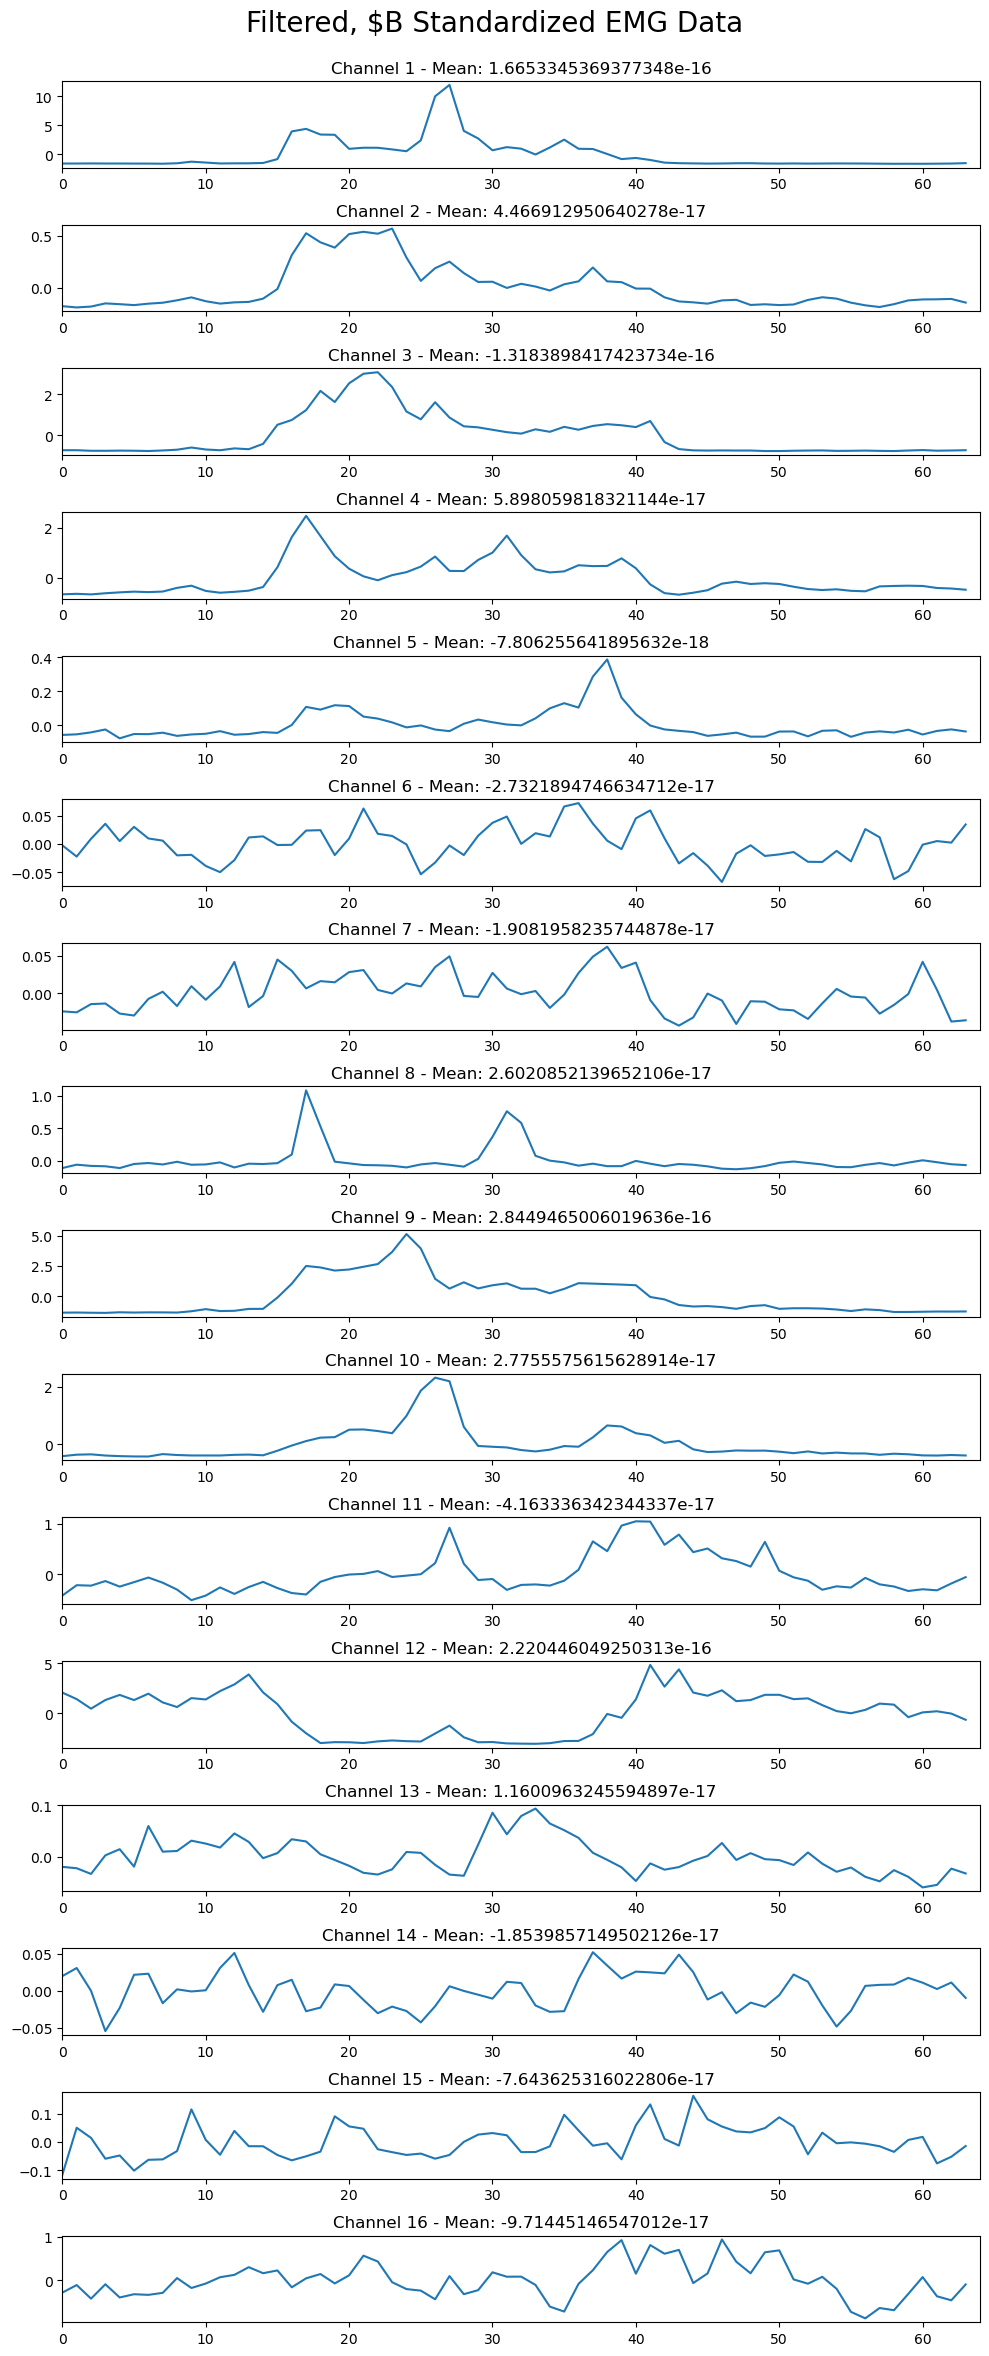

In [9]:
fig, axs = plt.subplots(16, 1, figsize=(10, 1.5*16))

for i in range(16):
    channel_data = expdef_df_None.iloc[0, 3][:, i]
    channel_mean = np.mean(channel_data)
    axs[i].plot(channel_data)
    axs[i].set_title(f'Channel {i + 1} - Mean: {channel_mean}')
    axs[i].set_xlim(0, len(channel_data))  # Set x limits to make all subplots the same width

plt.tight_layout()
plt.suptitle('Filtered, $B Standardized EMG Data', fontsize=20)
plt.subplots_adjust(top=0.95)  
plt.show()

In [10]:
# Generic model

generic_CNN_None_res = main_training_pipeline(
    shared_None_data_splits, 
    all_participants=all_participants, 
    test_participants=test_participants,
    model_type="CNN",
    config=DynamicCNN_config)

generic_CNNLSTM_None_res = main_training_pipeline(
    shared_None_data_splits, 
    all_participants=all_participants, 
    test_participants=test_participants,
    model_type="CNNLSTM",
    config=DynamicCNNLSTM_config)

Final Accuracies (averaged across users and gestures)
Train accuracy: 16.88%
Intra test accuracy: 16.88%
Cross test accuracy: 11.43%


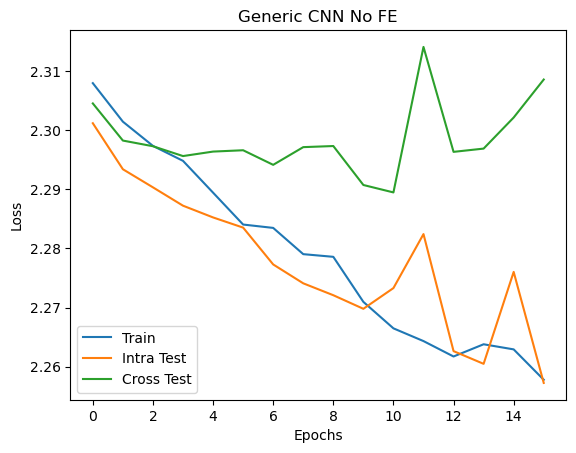

In [11]:
plot_train_test_curves(generic_CNN_None_res, "Generic CNN No FE")

Final Accuracies (averaged across users and gestures)
Train accuracy: 15.68%
Intra test accuracy: 15.62%
Cross test accuracy: 9.46%


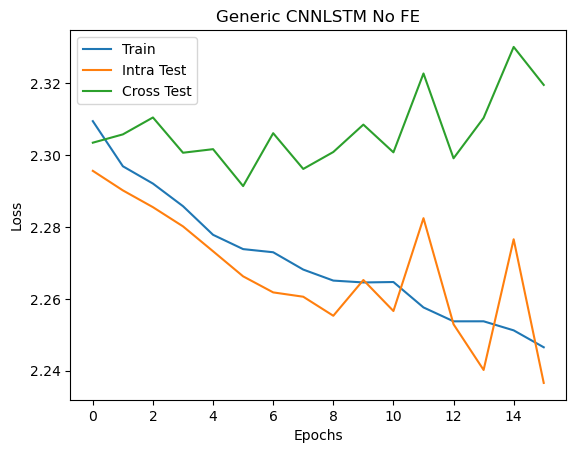

In [12]:
plot_train_test_curves(generic_CNNLSTM_None_res, "Generic CNNLSTM No FE")

In [19]:
# Local models (take the average)

data_splits = shared_None_data_splits

local_train_participants = list(set(data_splits['train']['participant_ids']))
num_local_train_participants = len(local_train_participants)

CNN_user_dict = prepare_data_for_local_models(data_splits, DynamicCNN_config)
CNNLSTM_user_dict = prepare_data_for_local_models(data_splits, DynamicCNNLSTM_config)

local_CNN_None_res_dict_lst = []
local_CNNLSTM_None_res_dict_lst = []
for p_idx, pid in enumerate(local_train_participants[:LOCAL_USERS_LIMIT]):
    print(f"Training local model for {pid} ({p_idx+1}/{len(local_train_participants)})")
    
    local_CNN_None_res_dict_lst.append((pid, main_training_pipeline(data_splits=None, all_participants=all_participants, 
                                            test_participants=data_splits['cross_subject_test']['participant_ids'], 
                                            model_type="CNN", config=DynamicCNN_config, 
                                            train_intra_cross_loaders=CNN_user_dict[pid])))
    
    local_CNNLSTM_None_res_dict_lst.append((pid, main_training_pipeline(data_splits=None, all_participants=all_participants, 
                                            test_participants=data_splits['cross_subject_test']['participant_ids'], 
                                            model_type="CNNLSTM", config=DynamicCNNLSTM_config, 
                                            train_intra_cross_loaders=CNNLSTM_user_dict[pid])))

Training local model for P119 (1/24)
Training local model for P107 (2/24)
Training local model for P124 (3/24)
Training local model for P110 (4/24)
Training local model for P122 (5/24)
Training local model for P109 (6/24)
Training local model for P131 (7/24)
Training local model for P004 (8/24)
Training local model for P112 (9/24)
Training local model for P005 (10/24)


Final Accuracies (averaged across users and gestures)
Train accuracy: 78.75%
Intra test accuracy: 85.00%
Cross test accuracy: 13.57%


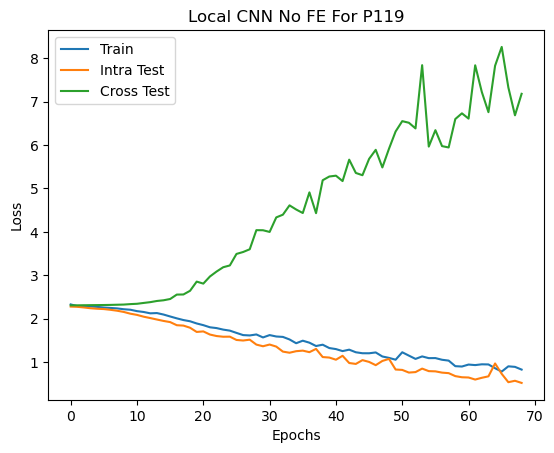

In [20]:
plot_train_test_curves(local_CNN_None_res_dict_lst[0][1], f"Local CNN No FE For {local_CNN_None_res_dict_lst[0][0]}")

# If the overfitting isn't too bad then I can just run all of them, and then write some code to average the final train/intra/cross accuracies
# Then somewhere below plot that as... a bar plot? Idk

## Khushaba Moments FE

In [21]:
FEATURE_ENGR_METHOD = "moments"

In [22]:
DynamicCNN_config["feature_engr"] = FEATURE_ENGR_METHOD
DynamicCNNLSTM_config["feature_engr"] = FEATURE_ENGR_METHOD
# Is num_channels and such correct? ... FE data has different number of channels...

# Load in the filtered (NOT STANDARDIZED) data!
expdef_df_moments = load_expdef_gestures(feateng_method=FEATURE_ENGR_METHOD, filepath_pkl='C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\metadata_EMG_allgestures_allusers.pkl')
shared_moments_data_splits_lst = create_shared_trial_data_splits(expdef_df_moments, all_participants, test_participants, num_monte_carlo_runs=NUM_MONTE_CARLO_RUNS, num_train_gesture_trials=8, num_ft_gesture_trials=3)
shared_moments_data_splits = shared_moments_data_splits_lst[0]

In [23]:
# Generic model

generic_CNN_moments_res = main_training_pipeline(
    shared_moments_data_splits, 
    all_participants=all_participants, 
    test_participants=test_participants,
    model_type="CNN",
    config=DynamicCNN_config)

generic_CNNLSTM_moments_res = main_training_pipeline(
    shared_moments_data_splits, 
    all_participants=all_participants, 
    test_participants=test_participants,
    model_type="CNNLSTM",
    config=DynamicCNNLSTM_config)

Final Accuracies (averaged across users and gestures)
Train accuracy: 18.75%
Intra test accuracy: 19.38%
Cross test accuracy: 15.18%


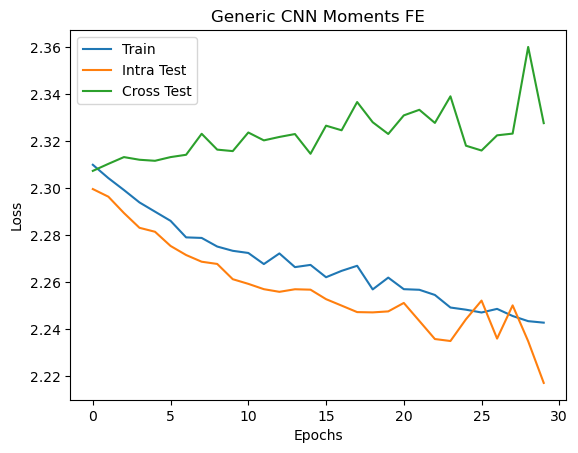

In [24]:
plot_train_test_curves(generic_CNN_moments_res, "Generic CNN Moments FE")

Final Accuracies (averaged across users and gestures)
Train accuracy: 18.39%
Intra test accuracy: 18.54%
Cross test accuracy: 12.50%


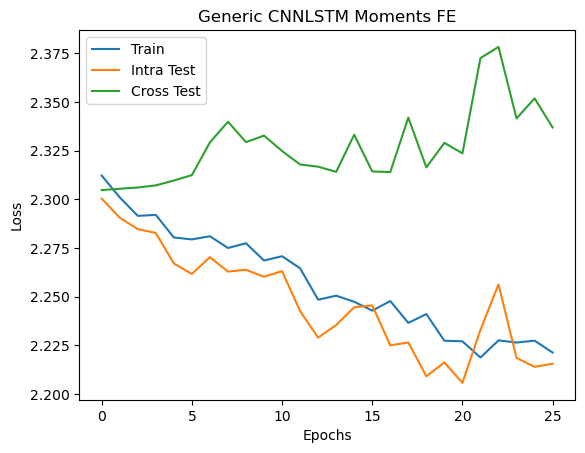

In [25]:
plot_train_test_curves(generic_CNNLSTM_moments_res, "Generic CNNLSTM Moments FE")

In [26]:
# Local models (take the average)

data_splits = shared_moments_data_splits

local_train_participants = list(set(data_splits['train']['participant_ids']))
num_local_train_participants = len(local_train_participants)

CNN_user_dict = prepare_data_for_local_models(data_splits, DynamicCNN_config)
CNNLSTM_user_dict = prepare_data_for_local_models(data_splits, DynamicCNNLSTM_config)

local_CNN_moments_res_dict_lst = []
local_CNNLSTM_moments_res_dict_lst = []
for p_idx, pid in enumerate(local_train_participants[:LOCAL_USERS_LIMIT]):
    print(f"Training local model for {pid} ({p_idx+1}/{len(local_train_participants)})")
    
    local_CNN_moments_res_dict_lst.append((pid, main_training_pipeline(data_splits=None, all_participants=all_participants, 
                                            test_participants=data_splits['cross_subject_test']['participant_ids'], 
                                            model_type="CNN", config=DynamicCNN_config, 
                                            train_intra_cross_loaders=CNN_user_dict[pid])))
    
    local_CNNLSTM_moments_res_dict_lst.append((pid, main_training_pipeline(data_splits=None, all_participants=all_participants, 
                                            test_participants=data_splits['cross_subject_test']['participant_ids'], 
                                            model_type="CNNLSTM", config=DynamicCNNLSTM_config, 
                                            train_intra_cross_loaders=CNNLSTM_user_dict[pid])))

Training local model for P119 (1/24)
Training local model for P107 (2/24)
Training local model for P124 (3/24)
Training local model for P110 (4/24)
Training local model for P122 (5/24)
Training local model for P109 (6/24)
Training local model for P131 (7/24)
Training local model for P004 (8/24)
Training local model for P112 (9/24)
Training local model for P005 (10/24)


## Time Domain ("FS") FE

In [27]:
FEATURE_ENGR_METHOD = "FS"

In [28]:
DynamicCNN_config["feature_engr"] = FEATURE_ENGR_METHOD
DynamicCNNLSTM_config["feature_engr"] = FEATURE_ENGR_METHOD
# Is num_channels and such correct? ... FE data has different number of channels...

# Load in the filtered (NOT STANDARDIZED) data!
expdef_df_FS = load_expdef_gestures(feateng_method=FEATURE_ENGR_METHOD, filepath_pkl='C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\metadata_EMG_allgestures_allusers.pkl')
shared_FS_data_splits_lst = create_shared_trial_data_splits(expdef_df_FS, all_participants, test_participants, num_monte_carlo_runs=NUM_MONTE_CARLO_RUNS, num_train_gesture_trials=8, num_ft_gesture_trials=3)
shared_FS_data_splits = shared_FS_data_splits_lst[0]

In [29]:
# Generic model

generic_CNN_FS_res = main_training_pipeline(
    shared_None_data_splits, 
    all_participants=all_participants, 
    test_participants=test_participants,
    model_type="CNN",
    config=DynamicCNN_config)

generic_CNNLSTM_FS_res = main_training_pipeline(
    shared_None_data_splits, 
    all_participants=all_participants, 
    test_participants=test_participants,
    model_type="CNNLSTM",
    config=DynamicCNNLSTM_config)

Final Accuracies (averaged across users and gestures)
Train accuracy: 18.70%
Intra test accuracy: 19.38%
Cross test accuracy: 11.25%


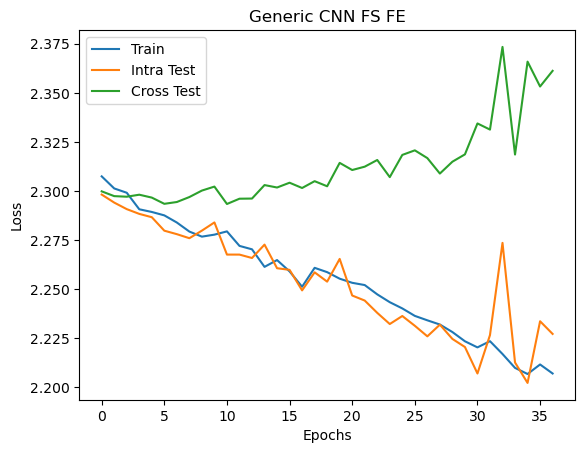

In [30]:
plot_train_test_curves(generic_CNN_FS_res, "Generic CNN FS FE")

Final Accuracies (averaged across users and gestures)
Train accuracy: 23.28%
Intra test accuracy: 22.71%
Cross test accuracy: 11.07%


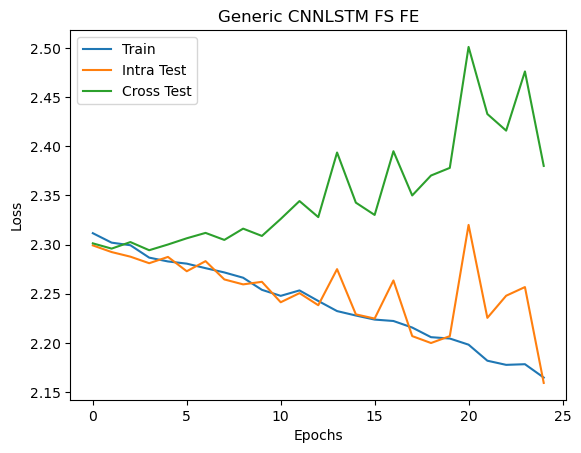

In [31]:
plot_train_test_curves(generic_CNNLSTM_FS_res, "Generic CNNLSTM FS FE")

In [32]:
# Local models (take the average)

data_splits = shared_FS_data_splits

local_train_participants = list(set(data_splits['train']['participant_ids']))
num_local_train_participants = len(local_train_participants)

CNN_user_dict = prepare_data_for_local_models(data_splits, DynamicCNN_config)
CNNLSTM_user_dict = prepare_data_for_local_models(data_splits, DynamicCNNLSTM_config)

local_CNN_FS_res_dict_lst = []
local_CNNLSTM_FS_res_dict_lst = []
for p_idx, pid in enumerate(local_train_participants[:LOCAL_USERS_LIMIT]):
    print(f"Training local model for {pid} ({p_idx+1}/{len(local_train_participants)})")
    
    local_CNN_FS_res_dict_lst.append((pid, main_training_pipeline(data_splits=None, all_participants=all_participants, 
                                            test_participants=data_splits['cross_subject_test']['participant_ids'], 
                                            model_type="CNN", config=DynamicCNN_config, 
                                            train_intra_cross_loaders=CNN_user_dict[pid])))
    
    local_CNNLSTM_FS_res_dict_lst.append((pid, main_training_pipeline(data_splits=None, all_participants=all_participants, 
                                            test_participants=data_splits['cross_subject_test']['participant_ids'], 
                                            model_type="CNNLSTM", config=DynamicCNNLSTM_config, 
                                            train_intra_cross_loaders=CNNLSTM_user_dict[pid])))

Training local model for P119 (1/24)
Training local model for P107 (2/24)
Training local model for P124 (3/24)
Training local model for P110 (4/24)
Training local model for P122 (5/24)
Training local model for P109 (6/24)
Training local model for P131 (7/24)
Training local model for P004 (8/24)
Training local model for P112 (9/24)
Training local model for P005 (10/24)


# Final Figure

In [33]:
generic_CNNLSTM_FS_res.keys()

dict_keys(['model', 'train_performance', 'intra_test_performance', 'cross_test_performance', 'train_accuracy', 'intra_test_accuracy', 'cross_test_accuracy', 'train_loss_log', 'intra_test_loss_log', 'cross_test_loss_log'])

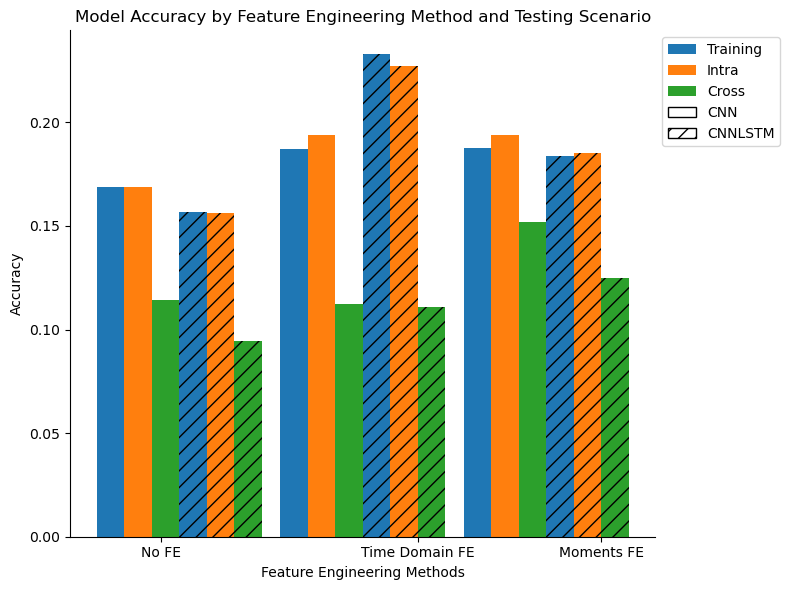

In [38]:
labels = ['No FE', 'Time Domain FE', 'Moments FE']
cnn_training = [generic_CNN_None_res['train_accuracy'], generic_CNN_FS_res['train_accuracy'], generic_CNN_moments_res['train_accuracy']]
cnn_intra = [generic_CNN_None_res['intra_test_accuracy'], generic_CNN_FS_res['intra_test_accuracy'], generic_CNN_moments_res['intra_test_accuracy']]
cnn_cross = [generic_CNN_None_res['cross_test_accuracy'], generic_CNN_FS_res['cross_test_accuracy'], generic_CNN_moments_res['cross_test_accuracy']]
cnnlstm_training = [generic_CNNLSTM_None_res['train_accuracy'], generic_CNNLSTM_FS_res['train_accuracy'], generic_CNNLSTM_moments_res['train_accuracy']]
cnnlstm_intra = [generic_CNNLSTM_None_res['intra_test_accuracy'], generic_CNNLSTM_FS_res['intra_test_accuracy'], generic_CNNLSTM_moments_res['intra_test_accuracy']]
cnnlstm_cross = [generic_CNNLSTM_None_res['cross_test_accuracy'], generic_CNNLSTM_FS_res['cross_test_accuracy'], generic_CNNLSTM_moments_res['cross_test_accuracy']]

x = np.arange(len(labels))  # Base positions
width = 0.15  # Bar width
small_gap = 0.1  # Small gap between CNN and CNN-LSTM groups
big_gap = 0.4  # Big gap between feature engineering categories

# Adjusted x positions for bars (fixing alignment)
x_cnn_train = x - (1.5 * width + small_gap / 2)  
x_cnn_intra = x - (0.5 * width + small_gap / 2)
x_cnn_cross = x + (0.5 * width - small_gap / 2)

x_cnnlstm_train = x + (1.5 * width - small_gap / 2)
x_cnnlstm_intra = x + (2.5 * width - small_gap / 2)
x_cnnlstm_cross = x + (3.5 * width - small_gap / 2)

# Shift entire set to allow for the big gap
x_shifted = x * (1 + big_gap)

# Fix the big gap misalignment issue for "Moments FE"
x_shifted[2] -= big_gap  # Adjust the last group to ensure it's centered

fig, ax = plt.subplots(figsize=(8, 6))

# Define colors and hatches
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Train (blue), Intra (orange), Cross (green)
hatches = ['', '//']  # CNN (solid), CNN-LSTM (hashed)

# Plot bars
ax.bar(x_cnn_train, cnn_training, width, color=colors[0], hatch=hatches[0], label='Training')
ax.bar(x_cnn_intra, cnn_intra, width, color=colors[1], hatch=hatches[0], label='Intra')
ax.bar(x_cnn_cross, cnn_cross, width, color=colors[2], hatch=hatches[0], label='Cross')

ax.bar(x_cnnlstm_train, cnnlstm_training, width, color=colors[0], hatch=hatches[1])
ax.bar(x_cnnlstm_intra, cnnlstm_intra, width, color=colors[1], hatch=hatches[1])
ax.bar(x_cnnlstm_cross, cnnlstm_cross, width, color=colors[2], hatch=hatches[1])

# Formatting
ax.set_xlabel('Feature Engineering Methods')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy by Feature Engineering Method and Testing Scenario')
ax.set_xticks(x_shifted)
ax.set_xticklabels(labels)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Custom Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Training'),
    Patch(facecolor=colors[1], label='Intra'),
    Patch(facecolor=colors[2], label='Cross'),
    Patch(facecolor='white', hatch=hatches[0], label='CNN', edgecolor='black', linewidth=1),
    Patch(facecolor='white', hatch=hatches[1], label='CNNLSTM', edgecolor='black', linewidth=1)
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

fig.tight_layout()
plt.show()
